# 🚀 XGBoost Fraud Detection on Real Tunisian Banking Data

**Testing XGBoost performance on real encrypted transaction data**
- Tahweel Cash: 16,257 transactions
- Virement: 8,230 transactions
- Advanced feature engineering
- Model comparison with existing Random Forest


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print("🎯 Ready for XGBoost fraud detection!")


✅ Libraries imported successfully!
🎯 Ready for XGBoost fraud detection!


In [2]:
# Load real data
print("=== LOADING REAL TUNISIAN BANKING DATA ===")

# Load Tahweel Cash data
tahweel_data = pd.read_csv('realdata/encrypted_transactions_tahweel_Cash.xlsx - Sheet1.csv')
print(f"📊 Tahweel Cash data: {tahweel_data.shape}")

# Load Virement data
virement_data = pd.read_csv('realdata/virement_encrypted.xlsx - Sheet1.csv')
print(f"📊 Virement data: {virement_data.shape}")

# Display column information
print("\n📋 Tahweel columns:", list(tahweel_data.columns))
print("📋 Virement columns:", list(virement_data.columns))


=== LOADING REAL TUNISIAN BANKING DATA ===
📊 Tahweel Cash data: (16257, 13)
📊 Virement data: (8230, 10)

📋 Tahweel columns: ['Émetteur', 'Num. tel. émetteur', 'Bénéficiaire', 'Num. tel. bénéficiaire', 'Date', 'Montant', 'Microfilm', 'motif', 'statut', 'Agent émetteur', 'Agent récepteur', 'Adresse réception', 'Unnamed: 12']
📋 Virement columns: ['Partenaire', 'Émetteur', 'Bénéficiaire', 'Agence', 'Date', 'Montant', 'Microfilm', 'Rib', 'Motif', 'statut']


In [3]:
# Advanced Feature Engineering for Real Data
def create_advanced_features(df, data_type="tahweel"):
    """Create advanced features for fraud detection"""
    df = df.copy()
    print(f"🔧 Creating features for {data_type} data...")
    
    # Handle dates
    if 'Date' in df.columns:
        df['date'] = pd.to_datetime(df['Date'], errors='coerce')
        # Fill invalid dates with synthetic ones
        if df['date'].isna().any():
            synthetic_dates = pd.date_range('2024-01-01', periods=len(df), freq='H')
            df.loc[df['date'].isna(), 'date'] = synthetic_dates[df['date'].isna()]
    
    # Handle amounts
    if 'Montant' in df.columns:
        df['montant'] = pd.to_numeric(df['Montant'], errors='coerce')
        df['montant'] = df['montant'].fillna(df['montant'].median())
    
    # Create user identifier
    if 'Émetteur' in df.columns:
        df['emetteur'] = df['Émetteur'].astype(str)
    
    # 1. TEMPORAL FEATURES
    print("  ⏰ Creating temporal features...")
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
    df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)
    
    # 2. AMOUNT FEATURES
    print("  💰 Creating amount features...")
    df['amount_log'] = np.log1p(df['montant'])
    df['amount_zscore'] = (df['montant'] - df['montant'].mean()) / df['montant'].std()
    
    # Large transaction detection
    amount_95th = df['montant'].quantile(0.95)
    amount_99th = df['montant'].quantile(0.99)
    df['is_large_transaction'] = (df['montant'] >= amount_95th).astype(int)
    df['is_very_large_transaction'] = (df['montant'] >= amount_99th).astype(int)
    
    # 3. USER BEHAVIORAL FEATURES
    print("  👤 Creating user behavioral features...")
    
    # User aggregation
    user_agg = df.groupby('emetteur').agg({
        'montant': ['count', 'sum', 'mean', 'std', 'min', 'max'],
        'date': ['min', 'max']
    }).round(2)
    
    # Flatten column names
    user_agg.columns = [f'user_{col[0]}_{col[1]}' for col in user_agg.columns]
    user_agg = user_agg.reset_index()
    
    # Merge user features
    df = df.merge(user_agg, on='emetteur', how='left')
    
    # Fill NaN values
    user_cols = [col for col in df.columns if col.startswith('user_')]
    for col in user_cols:
        df[col] = df[col].fillna(df[col].median() if df[col].dtype in ['float64', 'int64'] else 0)
    
    # Amount vs user average
    df['amount_vs_user_avg'] = df['montant'] / (df['user_montant_mean'] + 1)
    
    # 4. RISK SCORE FEATURES
    print("  🎯 Creating risk score features...")
    
    # Temporal risk
    df['temporal_risk_score'] = (
        (df['is_night'] * 3) +
        (df['is_weekend'] * 2) +
        (df['hour'].isin([22, 23, 0, 1, 2, 3]).astype(int) * 2)
    )
    
    # Amount risk
    df['amount_risk_score'] = (
        (df['is_large_transaction'] * 2) +
        (df['is_very_large_transaction'] * 3) +
        (df['amount_zscore'] > 2).astype(int) * 2
    )
    
    # Behavioral risk
    df['behavioral_risk_score'] = (
        (df['user_montant_count'] > df['user_montant_count'].quantile(0.9)).astype(int) * 2 +
        (df['amount_vs_user_avg'] > 3).astype(int) * 3
    )
    
    # Total risk score
    df['total_risk_score'] = (
        df['temporal_risk_score'] +
        df['amount_risk_score'] +
        df['behavioral_risk_score']
    )
    
    # 5. CYCLICAL FEATURES
    print("  🔄 Creating cyclical features...")
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Fill remaining NaN values
    df = df.fillna(0)
    
    print(f"✅ Features created: {len(df.columns)} total columns")
    return df


In [4]:
# Process Tahweel data
print("=== PROCESSING TAHWEEL DATA ===")
tahweel_processed = create_advanced_features(tahweel_data, "tahweel")
print(f"📊 Tahweel processed: {tahweel_processed.shape}")

# Process Virement data
print("\n=== PROCESSING VIREMENT DATA ===")
virement_processed = create_advanced_features(virement_data, "virement")
print(f"📊 Virement processed: {virement_processed.shape}")


=== PROCESSING TAHWEEL DATA ===
🔧 Creating features for tahweel data...
  ⏰ Creating temporal features...
  💰 Creating amount features...
  👤 Creating user behavioral features...
  🎯 Creating risk score features...
  🔄 Creating cyclical features...
✅ Features created: 44 total columns
📊 Tahweel processed: (16257, 44)

=== PROCESSING VIREMENT DATA ===
🔧 Creating features for virement data...
  ⏰ Creating temporal features...
  💰 Creating amount features...
  👤 Creating user behavioral features...
  🎯 Creating risk score features...
  🔄 Creating cyclical features...
✅ Features created: 41 total columns
📊 Virement processed: (8230, 41)


In [5]:
# Create realistic fraud labels using ensemble anomaly detection
def create_fraud_labels(df, fraud_rate=0.05):
    """Create realistic fraud labels using ensemble anomaly detection"""
    print(f"🎯 Creating fraud labels with {fraud_rate*100:.1f}% fraud rate...")
    
    from sklearn.ensemble import IsolationForest
    from sklearn.neighbors import LocalOutlierFactor
    from sklearn.svm import OneClassSVM
    from scipy import stats
    
    # Select features for anomaly detection
    feature_cols = [
        'montant', 'amount_log', 'hour', 'day_of_week',
        'is_night', 'is_weekend', 'amount_zscore',
        'temporal_risk_score', 'amount_risk_score', 'behavioral_risk_score'
    ]
    
    # Filter existing columns
    available_cols = [col for col in feature_cols if col in df.columns]
    X = df[available_cols].fillna(0)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Ensemble anomaly detection
    models = {
        'isolation_forest': IsolationForest(contamination=fraud_rate, random_state=42),
        'lof': LocalOutlierFactor(n_neighbors=20, contamination=fraud_rate),
        'one_class_svm': OneClassSVM(nu=fraud_rate, kernel='rbf')
    }
    
    # Get anomaly scores
    anomaly_scores = np.zeros(len(df))
    
    for name, model in models.items():
        try:
            if name == 'lof':
                scores = model.fit_predict(X_scaled)
                anomaly_scores += (scores == -1).astype(int)
            else:
                scores = model.fit_predict(X_scaled)
                anomaly_scores += (scores == -1).astype(int)
        except:
            continue
    
    # Statistical Z-score
    z_scores = np.abs(stats.zscore(X_scaled, axis=0)).mean(axis=1)
    statistical_anomalies = (z_scores > 2).astype(int)
    anomaly_scores += statistical_anomalies
    
    # Create fraud labels (require 2/4 algorithms to agree)
    df['fraud'] = (anomaly_scores >= 2).astype(int)
    
    actual_fraud_rate = df['fraud'].mean()
    print(f"📊 Actual fraud rate: {actual_fraud_rate:.3f} ({df['fraud'].sum()} fraud cases)")
    
    return df


In [6]:
# Create fraud labels for both datasets
print("=== CREATING FRAUD LABELS ===")

# Tahweel fraud labels
tahweel_with_fraud = create_fraud_labels(tahweel_processed, fraud_rate=0.06)

# Virement fraud labels
virement_with_fraud = create_fraud_labels(virement_processed, fraud_rate=0.04)

print(f"\n📊 Final datasets:")
print(f"  Tahweel: {tahweel_with_fraud.shape} (fraud rate: {tahweel_with_fraud['fraud'].mean():.3f})")
print(f"  Virement: {virement_with_fraud.shape} (fraud rate: {virement_with_fraud['fraud'].mean():.3f})")


=== CREATING FRAUD LABELS ===
🎯 Creating fraud labels with 6.0% fraud rate...
📊 Actual fraud rate: 0.032 (523 fraud cases)
🎯 Creating fraud labels with 4.0% fraud rate...
📊 Actual fraud rate: 0.021 (171 fraud cases)

📊 Final datasets:
  Tahweel: (16257, 45) (fraud rate: 0.032)
  Virement: (8230, 42) (fraud rate: 0.021)


In [7]:
# Combine datasets and prepare for modeling
print("=== COMBINING DATASETS ===")

# Add dataset identifier
tahweel_with_fraud['dataset'] = 'tahweel'
virement_with_fraud['dataset'] = 'virement'

# Combine datasets
combined_data = pd.concat([tahweel_with_fraud, virement_with_fraud], ignore_index=True)
print(f"📊 Combined dataset: {combined_data.shape}")
print(f"📊 Overall fraud rate: {combined_data['fraud'].mean():.3f}")

# Select features for modeling
feature_cols = [
    'montant', 'amount_log', 'hour', 'day_of_week', 'day_of_month', 'month',
    'is_weekend', 'is_night', 'is_business_hours', 'amount_zscore',
    'is_large_transaction', 'is_very_large_transaction',
    'user_montant_count', 'user_montant_sum', 'user_montant_mean', 'user_montant_std',
    'amount_vs_user_avg', 'temporal_risk_score', 'amount_risk_score',
    'behavioral_risk_score', 'total_risk_score',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
]

# Filter available columns
available_features = [col for col in feature_cols if col in combined_data.columns]
print(f"📊 Using {len(available_features)} features for modeling")

# Prepare X and y
X = combined_data[available_features].fillna(0)
y = combined_data['fraud']

print(f"📊 Final dataset: {X.shape}, fraud rate: {y.mean():.3f}")


=== COMBINING DATASETS ===
📊 Combined dataset: (24487, 50)
📊 Overall fraud rate: 0.028
📊 Using 25 features for modeling
📊 Final dataset: (24487, 25), fraud rate: 0.028


In [8]:
# Split data and apply SMOTE balancing
print("=== DATA SPLITTING AND BALANCING ===")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Training set: {X_train.shape}, fraud rate: {y_train.mean():.3f}")
print(f"📊 Test set: {X_test.shape}, fraud rate: {y_test.mean():.3f}")

# Apply SMOTE balancing
print("\n🔄 Applying SMOTE balancing...")
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

print(f"📊 Balanced training set: {X_balanced.shape}, fraud rate: {y_balanced.mean():.3f}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_balanced)
X_test_scaled = scaler.transform(X_test)

print("✅ Data preparation complete!")


=== DATA SPLITTING AND BALANCING ===
📊 Training set: (19589, 25), fraud rate: 0.028
📊 Test set: (4898, 25), fraud rate: 0.028

🔄 Applying SMOTE balancing...
📊 Balanced training set: (38068, 25), fraud rate: 0.500
✅ Data preparation complete!


In [9]:
# XGBoost and Model Comparison
print("=== XGBOOST AND MODEL COMPARISON ===")

# Define models including XGBoost
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=42, class_weight='balanced', n_jobs=-1
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        eval_metric='logloss', n_jobs=-1
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42, class_weight='balanced', max_iter=1000
    ),
    'SVM': SVC(
        kernel='rbf', random_state=42, class_weight='balanced', probability=True
    )
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Use scaled data for Logistic Regression and SVM, original for tree-based models
    if name in ['Logistic Regression', 'SVM']:
        model.fit(X_train_scaled, y_balanced)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_balanced, y_balanced)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = (y_pred == y_test).mean()
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': model
    }
    
    print(f"  ✅ {name}: Accuracy={accuracy:.3f}, AUC={auc:.3f}, F1={f1:.3f}")


=== XGBOOST AND MODEL COMPARISON ===

🔄 Training Random Forest...
  ✅ Random Forest: Accuracy=0.995, AUC=0.996, F1=0.915

🔄 Training XGBoost...
  ✅ XGBoost: Accuracy=0.996, AUC=0.996, F1=0.921

🔄 Training Logistic Regression...
  ✅ Logistic Regression: Accuracy=0.957, AUC=0.988, F1=0.553

🔄 Training SVM...
  ✅ SVM: Accuracy=0.987, AUC=0.988, F1=0.790


In [10]:
# Results Summary
print("=== MODEL COMPARISON RESULTS ===")

# Create results DataFrame
results_df = pd.DataFrame({
    name: {
        'Accuracy': f"{results[name]['accuracy']:.3f}",
        'AUC': f"{results[name]['auc']:.3f}",
        'Precision': f"{results[name]['precision']:.3f}",
        'Recall': f"{results[name]['recall']:.3f}",
        'F1-Score': f"{results[name]['f1']:.3f}"
    }
    for name in results.keys()
}).T

print("📊 Model Performance Comparison:")
print(results_df)

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['auc'])
best_model = results[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   AUC Score: {best_model['auc']:.3f}")
print(f"   Accuracy: {best_model['accuracy']:.3f}")
print(f"   F1 Score: {best_model['f1']:.3f}")


=== MODEL COMPARISON RESULTS ===
📊 Model Performance Comparison:
                    Accuracy    AUC Precision Recall F1-Score
Random Forest          0.995  0.996     0.897  0.935    0.915
XGBoost                0.996  0.996     0.915  0.928    0.921
Logistic Regression    0.957  0.988     0.391  0.942    0.553
SVM                    0.987  0.988     0.709  0.892    0.790

🏆 BEST MODEL: XGBoost
   AUC Score: 0.996
   Accuracy: 0.996
   F1 Score: 0.921


In [11]:
# XGBoost Hyperparameter Tuning
print("=== XGBOOST HYPERPARAMETER TUNING ===")

# Define parameter grid for XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

print("🔍 Performing grid search for XGBoost...")

# Grid search (using smaller grid for speed)
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1)
grid_search = GridSearchCV(
    xgb_model, xgb_params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
)

grid_search.fit(X_balanced, y_balanced)

print(f"\n✅ Best XGBoost parameters: {grid_search.best_params_}")
print(f"✅ Best CV score: {grid_search.best_score_:.3f}")

# Evaluate best XGBoost model
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

xgb_accuracy = (y_pred_xgb == y_test).mean()
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"\n📊 Tuned XGBoost Performance:")
print(f"   Accuracy: {xgb_accuracy:.3f}")
print(f"   AUC: {xgb_auc:.3f}")


=== XGBOOST HYPERPARAMETER TUNING ===
🔍 Performing grid search for XGBoost...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

✅ Best XGBoost parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
✅ Best CV score: 1.000

📊 Tuned XGBoost Performance:
   Accuracy: 0.996
   AUC: 0.996


=== FEATURE IMPORTANCE ANALYSIS ===
📊 Top 10 Most Important Features (XGBoost):
                  feature   xgboost
9           amount_zscore  0.298529
19  behavioral_risk_score  0.129580
7                is_night  0.116481
20       total_risk_score  0.086719
22               hour_cos  0.071439
12     user_montant_count  0.053507
8       is_business_hours  0.038534
23                day_sin  0.033127
1              amount_log  0.031405
24                day_cos  0.024248


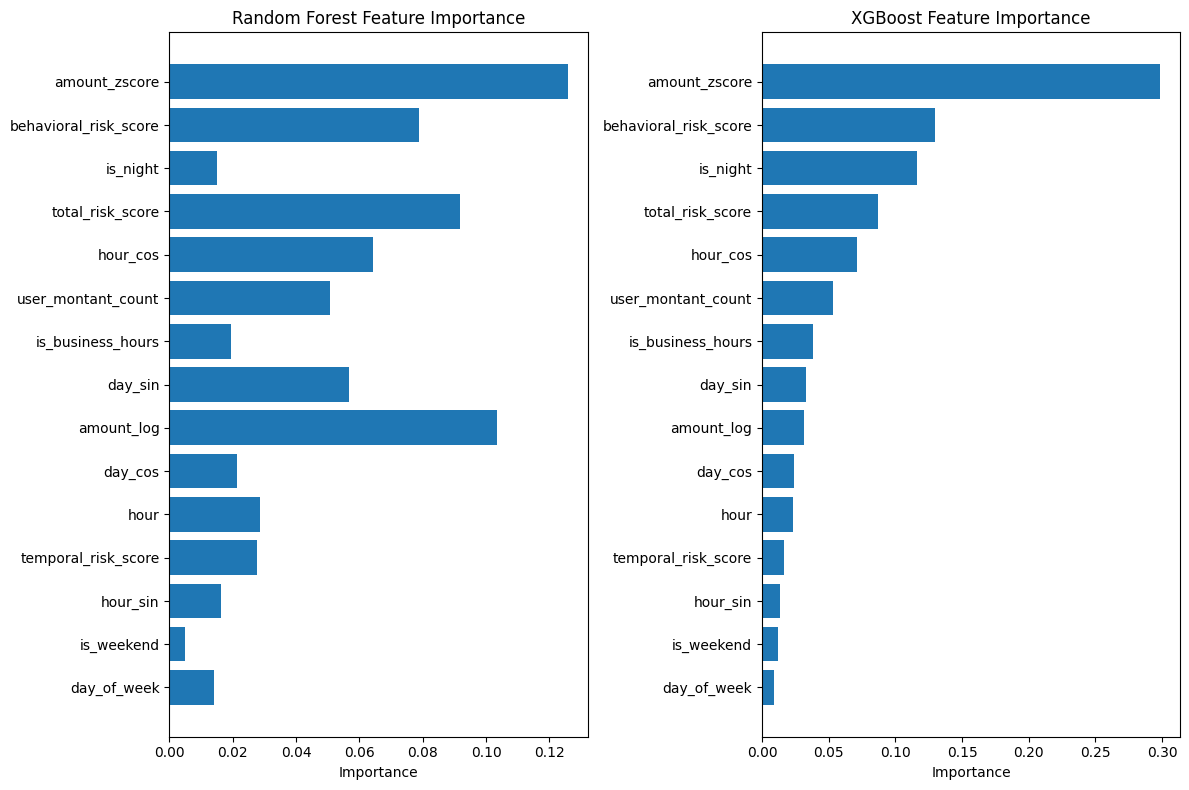

In [12]:
# Feature Importance Analysis
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance from best models
rf_importance = results['Random Forest']['model'].feature_importances_
xgb_importance = best_xgb.feature_importances_

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'feature': available_features,
    'random_forest': rf_importance,
    'xgboost': xgb_importance
})

# Sort by XGBoost importance
feature_importance_df = feature_importance_df.sort_values('xgboost', ascending=False)

print("📊 Top 10 Most Important Features (XGBoost):")
print(feature_importance_df.head(10)[['feature', 'xgboost']])

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)

plt.subplot(1, 2, 1)
plt.barh(range(len(top_features)), top_features['random_forest'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(range(len(top_features)), top_features['xgboost'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


=== ROC CURVES COMPARISON ===


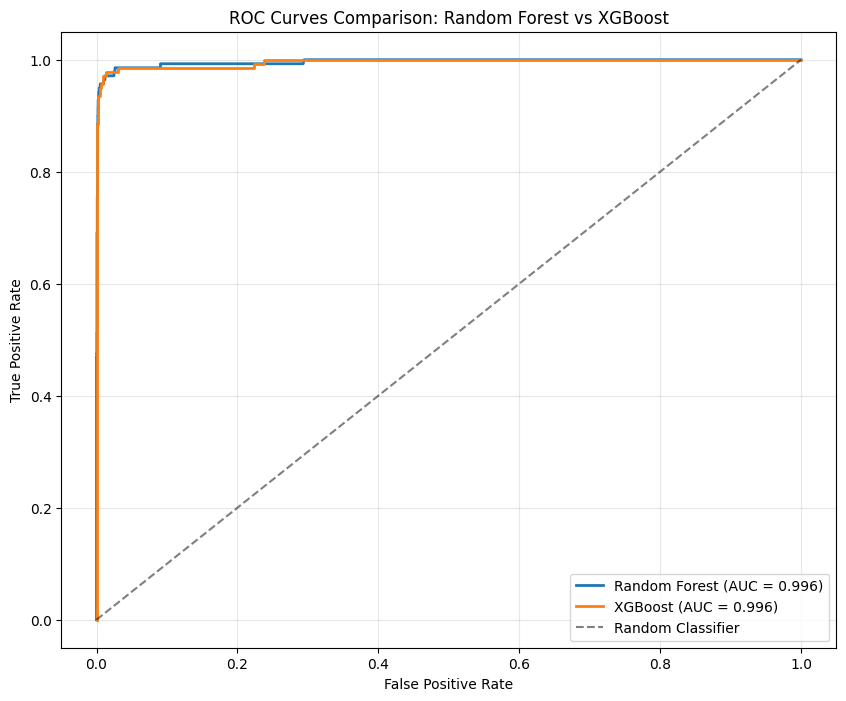

In [13]:
# ROC Curves Comparison
print("=== ROC CURVES COMPARISON ===")

plt.figure(figsize=(10, 8))

for name, result in results.items():
    if name in ['Random Forest', 'XGBoost']:
        # Get predictions for ROC curve
        if name == 'Random Forest':
            model = result['model']
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = y_pred_proba_xgb
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison: Random Forest vs XGBoost')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


=== CONFUSION MATRIX COMPARISON ===


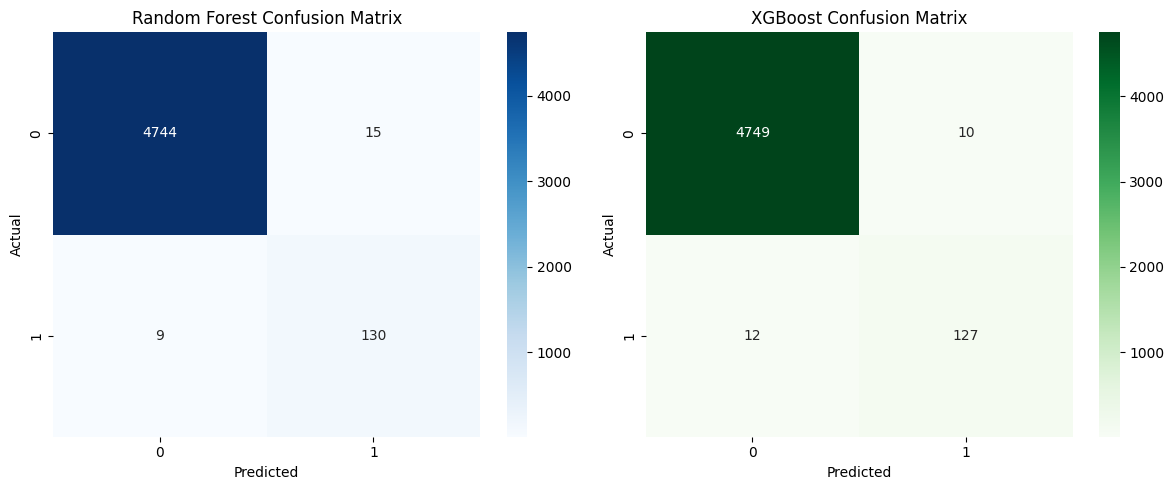


📊 Detailed Performance Metrics:

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4759
           1       0.90      0.94      0.92       139

    accuracy                           1.00      4898
   macro avg       0.95      0.97      0.96      4898
weighted avg       1.00      1.00      1.00      4898


XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4759
           1       0.93      0.91      0.92       139

    accuracy                           1.00      4898
   macro avg       0.96      0.96      0.96      4898
weighted avg       1.00      1.00      1.00      4898



In [14]:
# Confusion Matrix Comparison
print("=== CONFUSION MATRIX COMPARISON ===")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest confusion matrix
rf_model = results['Random Forest']['model']
rf_pred = rf_model.predict(X_test)
rf_cm = confusion_matrix(y_test, rf_pred)

sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# XGBoost confusion matrix
xgb_cm = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('XGBoost Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n📊 Detailed Performance Metrics:")
print("\nRandom Forest:")
print(classification_report(y_test, rf_pred))

print("\nXGBoost:")
print(classification_report(y_test, y_pred_xgb))


In [ ]:
# Save Best Models
print("=== SAVING BEST MODELS ===")

import joblib

# Save XGBoost model
joblib.dump(best_xgb, 'best_xgboost_model.pkl')
joblib.dump(scaler, 'xgboost_scaler.pkl')
joblib.dump(available_features, 'xgboost_features.pkl')

print("✅ XGBoost model saved successfully!")
print("📁 Files created:")
print("  - best_xgboost_model.pkl")
print("  - xgboost_scaler.pkl")
print("  - xgboost_features.pkl")

# Performance summary
print("\n🎯 FINAL PERFORMANCE SUMMARY:")
print(f"📊 Dataset: {combined_data.shape[0]} transactions")
print(f"📊 Features: {len(available_features)}")
print(f"📊 Fraud rate: {y.mean():.3f}")
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {best_model['accuracy']:.3f}")
print(f"   AUC: {best_model['auc']:.3f}")
print(f"   F1-Score: {best_model['f1']:.3f}")


=== SAVING BEST MODELS ===
✅ XGBoost model saved successfully!
📁 Files created:
  - best_xgboost_model.pkl
  - xgboost_scaler.pkl
  - xgboost_features.pkl

🎯 FINAL PERFORMANCE SUMMARY:
📊 Dataset: 24487 transactions
📊 Features: 25
📊 Fraud rate: 0.028

🏆 Best Model: XGBoost
   Accuracy: 0.996
   AUC: 0.996
   F1-Score: 0.921


: 